# Prophet Workflow Summary
## Data Preparation & Exploration
- Data Preprocessing → Clean & prepare data (handle missing values, outliers, convert ds to datetime)
- Exploratory Data Analysis (EDA) → Understand trends, seasonality, and correlations
- Feature Engineering → Create useful variables (lags, moving averages, categorical encoding)
## Prophet Model Workflow
- Step 1: Create Prophet model instance
- Step 2: Add regressors (holidays, weather, events, etc.)
- Step 3: Fit the model on training data
- Step 4: Extract & interpret regressor coefficients
- Step 5: Performance Metrics → Evaluate using cross-validation (MAE, RMSE, MAPE)
- Step 6: Visualization & Interpretation → Plot forecasts & component analysis
- Step 7: Forecast future values

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [56]:
# df = pd.read_csv("../data/preprocessed-data.csv")
df = pd.read_csv("../data/featured_data.csv")
holidays = pd.read_csv("../data/holidays.csv")

In [67]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'ds', 'holiday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'y', 'weathersit_2',
       'weathersit_3', 'temp_lag_1', 'atemp_lag_1', 'temp_lag_3',
       'atemp_lag_3', 'temp_lag_5', 'atemp_lag_5', 'temp_lag_7',
       'atemp_lag_7'],
      dtype='object')

In [57]:
df['ds'] = pd.to_datetime(df['ds'])
holidays['ds'] = holidays['ds'].astype(str).str.strip()
holidays['ds'] = holidays['ds'].str.split().str[0]  # Keeps only the YYYY-MM-DD part
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%Y-%m-%d', errors='coerce')

In [58]:
holidays.head()


,Unnamed: 0,holiday,ds,lower_window,upper_window
0,16,gen_holi,2011-01-17,-2,2
1,51,gen_holi,2011-02-21,-2,2
2,104,gen_holi,2011-04-15,-2,2
3,149,gen_holi,2011-05-30,-2,2
4,184,gen_holi,2011-07-04,-2,2


In [75]:
m = Prophet(holidays = holidays,
            seasonality_mode="multiplicative",
            seasonality_prior_scale=10, # default value 10
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor("workingday")
m.add_regressor("weathersit")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.add_regressor('temp_lag_1')
m.add_regressor('atemp_lag_1')
m.fit(df)

13:43:51 - cmdstanpy - INFO - Chain [1] start processing
13:43:52 - cmdstanpy - INFO - Chain [1] done processing


### Column	Meaning
- `regressor`:Name of the external regressor (e.g., temp, humidity, workingday, etc.)
- `regressor_mode`:How the regressor affects the model: additive (directly added to yhat) or multiplicative (scales yhat)
- `center`:Mean value of the regressor (used for normalization)
- `coef_lower`:Lower bound of the coefficient (confidence interval)
- `coef`:Estimated effect of the regressor on the forecast
- `coef_upper`:Upper bound of the coefficient (confidence interval)

#### `Confifdence Interval`
- A Confidence Interval (CI) gives an estimated range of values that the true effect of a regressor is likely to fall within.
- It helps measure uncertainty in predictions.



In [76]:
# Regressor Coefficient
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,4.245350,4.245350,4.245350
1,weathersit,multiplicative,1.384726,-1.648511,-1.648511,-1.648511
2,temp,multiplicative,0.505308,4.055902,4.055902,4.055902
3,atemp,multiplicative,0.483118,2.646798,2.646798,2.646798
4,hum,multiplicative,0.626288,-1.384841,-1.384841,-1.384841
5,windspeed,multiplicative,0.190637,-1.989188,-1.989188,-1.989188
6,weathersit_2,multiplicative,0.000000,1.282770,1.282770,1.282770
7,weathersit_3,multiplicative,0.000000,1.651650,1.651650,1.651650
8,temp_lag_1,multiplicative,0.505161,-0.766069,-0.766069,-0.766069
9,atemp_lag_1,multiplicative,0.482962,0.279631,0.279631,0.279631


### Key Takeaways

- People rent more bikes on working days.
- Bad weather (wind, humidity, rain) decreases rentals.
- Higher temperatures encourage more bike usage.
- Wind speed has the strongest negative effect (makes sense, as cycling in strong wind is difficult).

In [77]:
import pandas as pd

def interpret_prophet_coefficients(df):
    if 'regressor' not in df.columns or 'coef' not in df.columns:
        raise ValueError("DataFrame must contain 'regressor' and 'coef' columns.")
    
    print("Interpreting Prophet Model Coefficients\n")
    
    for i, row in df.iterrows():
        regressor = row['regressor']
        coef = row['coef']
        mode = row.get('regressor_mode', 'unknown')  # Handle missing column
        
        impact = "INCREASES" if coef > 0 else "DECREASES"
        effect_size = "strongly" if abs(coef) > 0.5 else "moderately" if abs(coef) > 0.2 else "weakly"
        
        print(f"{i+1} -> {regressor} ({mode} mode) {impact} predictions {effect_size} ({coef:.3f})")

    print("\n Larger absolute values mean stronger influence on forecasts.")

interpret_prophet_coefficients(regressor_coefficients(m))

Interpreting Prophet Model Coefficients

1 -> workingday (multiplicative mode) INCREASES predictions strongly (4.245)
2 -> weathersit (multiplicative mode) DECREASES predictions strongly (-1.649)
3 -> temp (multiplicative mode) INCREASES predictions strongly (4.056)
4 -> atemp (multiplicative mode) INCREASES predictions strongly (2.647)
5 -> hum (multiplicative mode) DECREASES predictions strongly (-1.385)
6 -> windspeed (multiplicative mode) DECREASES predictions strongly (-1.989)
7 -> weathersit_2 (multiplicative mode) INCREASES predictions strongly (1.283)
8 -> weathersit_3 (multiplicative mode) INCREASES predictions strongly (1.652)
9 -> temp_lag_1 (multiplicative mode) DECREASES predictions strongly (-0.766)
10 -> atemp_lag_1 (multiplicative mode) INCREASES predictions moderately (0.280)

 Larger absolute values mean stronger influence on forecasts.


## Cross Validation

In [78]:
# initial is the length of the initial training period before cross-validation starts. Prophet uses this to train the model before making predictions on the validation set.
df.shape[0] - 180

514

### Column	Meaning
- `ds`:The actual date/time of the forecast
- `yhat`:The predicted value (forecast) by Prophet
- `yhat_lower`:The lower bound of the uncertainty interval (confidence interval)
- `yhat_upper`:The upper bound of the uncertainty interval
- `y`:The actual observed value (ground truth)
- `cutoff`:The last date Prophet used for training before making this prediction

In [79]:
df_cv = cross_validation(model=m,
                         horizon = '30 days',
                         period='15 days',
                         initial='521 days',
                         parallel='processes')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8658.174524,7907.360444,9445.697735,6211,2012-06-19
1,2012-06-21,9017.930734,8255.312355,9841.998498,5905,2012-06-19
2,2012-06-22,8624.290843,7802.421646,9428.799354,5823,2012-06-19
3,2012-06-23,8224.484101,7490.297581,8951.026069,7458,2012-06-19
4,2012-06-24,8255.333475,7468.593132,9039.823459,6891,2012-06-19


In [80]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.145646e+06,1464.802462,1189.377840,0.205773,0.146079,0.185214,0.433333
1,4 days,2.273735e+06,1507.890752,1199.980997,0.203569,0.126367,0.182807,0.400000
2,5 days,1.983826e+06,1408.483618,1122.034722,0.188143,0.108259,0.168929,0.466667
3,6 days,1.285980e+06,1134.010785,932.772402,0.149071,0.107032,0.141090,0.500000
4,7 days,1.023851e+06,1011.855094,829.869069,0.127367,0.093760,0.125689,0.633333
5,8 days,8.124985e+05,901.386989,697.037074,0.100333,0.075870,0.102532,0.766667
6,9 days,7.494607e+05,865.713999,659.305691,0.094728,0.070326,0.094545,0.766667
7,10 days,1.119828e+06,1058.219178,716.482186,0.105853,0.073305,0.099843,0.733333
8,11 days,1.373862e+06,1172.118803,817.907893,0.125480,0.080862,0.115895,0.600000
9,12 days,1.865071e+06,1365.676195,998.673000,0.159445,0.121930,0.150169,0.500000


In [81]:
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
mape = round(performance_metrics(df_cv)['mape'].mean()*100,2)
mae = round(performance_metrics(df_cv)['mae'].mean(),0)
print(f"The RMSE is {rmse}")
print(f"The MAE is {mae}")
print(f"The MAPE is {mape}%")

The RMSE is 1359.0
The MAE is 1083.0
The MAPE is 18.48%


The RMSE is 1401.0

The MAE is 1114.0

The MAPE is 109.98%

A MAPE of 109.98% suggests that, on average, the model's predictions are more than 100% off from the actual values, which indicates very poor predictive performance. This could mean:

- The model isn't well-fitted to the data.
- There might be large outliers affecting the error.
- The data distribution or scale isn't suitable for the current model.

d:\Machine Learning\TimeSeries\timeVenv\lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
d:\Machine Learning\TimeSeries\timeVenv\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


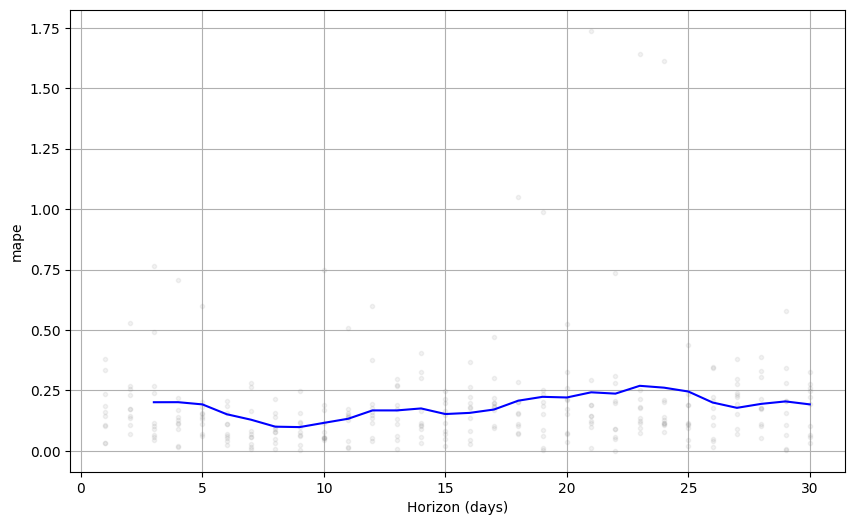

In [52]:
plot_cross_validation_metric(df_cv,metric='mape');

## Note: The error is resolved in data-preprocessing
### Exploring the Error
- There is a massive deviation_% on 2012-10-29

🤔**WHY??**

On October 29, 2012, Hurricane Sandy hit the U.S. East Coast, causing significant impacts in Washington, D.C. and surrounding areas.

**Solution**

I am going to replace the value of this date to its forward value in data_preprocessing

In [53]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']
df_cv['deviation_%'] = (df_cv['yhat']/df_cv['y'] - 1) * 100

In [54]:
# days with highest deviation
df_cv.sort_values(by='deviation_%',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
290,2012-11-22,6639.100005,5743.105215,7440.928919,2425,2012-11-01,4214.100005,173.777320
292,2012-11-24,6015.144835,5135.408954,6910.249617,2277,2012-11-01,3738.144835,164.169734
293,2012-11-25,6331.949294,5504.106567,7239.602635,2424,2012-11-01,3907.949294,161.219030
17,2012-07-07,9928.198288,9181.896788,10692.873904,4840,2012-06-19,5088.198288,105.128064
18,2012-07-08,9288.429532,8469.182534,10035.150540,4672,2012-06-19,4616.429532,98.810564
32,2012-07-07,8534.799903,7726.347007,9360.514459,4840,2012-07-04,3694.799903,76.338841
9,2012-06-29,9543.671945,8742.884115,10449.506465,5463,2012-06-19,4080.671945,74.696539
291,2012-11-23,6789.892270,5901.205401,7638.311899,3910,2012-11-01,2879.892270,73.654534
33,2012-07-08,7980.484962,7201.569062,8770.278941,4672,2012-07-04,3308.484962,70.815175
11,2012-07-01,8853.043355,8110.303130,9643.202003,5531,2012-06-19,3322.043355,60.062256


In [55]:
df_cv.sort_values(by='deviation_%',ascending=True).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
103,2012-08-17,4249.703179,3375.767437,5067.006141,7148,2012-08-03,-2898.296821,-40.546962
236,2012-10-29,2770.508282,1934.968768,3596.483651,4459,2012-10-02,-1688.491718,-37.867049
251,2012-10-29,2783.616755,1929.492809,3667.432992,4459,2012-10-17,-1675.383245,-37.573071
88,2012-08-17,4683.683189,3804.177082,5521.646001,7148,2012-07-19,-2464.316811,-34.475613
141,2012-09-09,5677.036887,4817.580599,6604.807145,8227,2012-08-18,-2549.963113,-30.995054
147,2012-09-15,6051.876819,5252.540155,6927.459992,8714,2012-08-18,-2662.123181,-30.549956
176,2012-09-29,6001.821171,5129.814672,6838.075170,8555,2012-09-02,-2553.178829,-29.844288
170,2012-09-23,5599.139626,4762.186783,6442.347523,7907,2012-09-02,-2307.860374,-29.187560
156,2012-09-09,5910.079820,5019.033135,6816.058889,8227,2012-09-02,-2316.920180,-28.162394
162,2012-09-15,6346.490057,5487.265276,7181.524902,8714,2012-09-02,-2367.509943,-27.169038


## Parameter Tuning

In [87]:
param_grid = {
    'changepoint_prior_scale': [0.05,0.5],
    'seasonality_prior_scale': [10,20],
    'holidays_prior_scale': [10,20],
    'seasonality_mode':['additive','multiplicative']
}

In [88]:
all_params = list(ParameterGrid(param_grid=param_grid))
len(all_params)

16

In [89]:
tuning_results = []

# Pipeline for parameter tuning
for params in all_params:
    #build the mode
    m = Prophet(holidays = holidays,
                **params)
    m.add_regressor("workingday")
    m.add_regressor("weathersit")
    m.add_regressor("temp")
    m.add_regressor("atemp")
    m.add_regressor("hum")
    m.add_regressor("windspeed")
    m.add_regressor("weathersit_2")
    m.add_regressor("weathersit_3")
    m.add_regressor('temp_lag_1')
    m.add_regressor('atemp_lag_1')
    m.fit(df)
    # cross_validation
    df_cv = cross_validation(model=m,
                            horizon = '30 days',
                            period='15 days',
                            initial='521 days',
                            parallel='processes')
    # compute and store error
    rmse = performance_metrics(df_cv)['rmse'].mean()
    tuning_results.append(rmse)

13:55:04 - cmdstanpy - INFO - Chain [1] start processing
13:55:04 - cmdstanpy - INFO - Chain [1] done processing
13:55:07 - cmdstanpy - INFO - Chain [1] start processing
13:55:07 - cmdstanpy - INFO - Chain [1] done processing
13:55:10 - cmdstanpy - INFO - Chain [1] start processing
13:55:10 - cmdstanpy - INFO - Chain [1] done processing
13:55:13 - cmdstanpy - INFO - Chain [1] start processing
13:55:13 - cmdstanpy - INFO - Chain [1] done processing
13:55:16 - cmdstanpy - INFO - Chain [1] start processing
13:55:16 - cmdstanpy - INFO - Chain [1] done processing
13:55:19 - cmdstanpy - INFO - Chain [1] start processing
13:55:19 - cmdstanpy - INFO - Chain [1] done processing
13:55:22 - cmdstanpy - INFO - Chain [1] start processing
13:55:22 - cmdstanpy - INFO - Chain [1] done processing
13:55:25 - cmdstanpy - INFO - Chain [1] start processing
13:55:26 - cmdstanpy - INFO - Chain [1] done processing
13:55:29 - cmdstanpy - INFO - Chain [1] start processing
13:55:29 - cmdstanpy - INFO - Chain [1]

In [90]:
# Parameter Tuning outcomes

outcome = pd.DataFrame(all_params)
outcome['tuning_results'] = tuning_results
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,1112.397539
1,0.05,10,additive,20,1112.892750
2,0.05,10,multiplicative,10,1358.539774
3,0.05,10,multiplicative,20,1350.983854
4,0.05,20,additive,10,1110.849967
5,0.05,20,additive,20,1114.192163
6,0.05,20,multiplicative,10,1379.377242
7,0.05,20,multiplicative,20,1360.577019
8,0.50,10,additive,10,1184.263732
9,0.50,10,additive,20,1185.034144


In [93]:
# Fetch the best params
best_params = all_params[tuning_results.index(min(tuning_results))]
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 20,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}